<a href="https://www.kaggle.com/code/kenny3s/find-best-params?scriptVersionId=167603970" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from torchvision.models import mobilenet_v2
import pandas as pd
from PIL import Image
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_ubyte, io
import matplotlib.pyplot as plt
# 检查是否有可用的GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 128
epoch = 100
early_stopping = 20

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.mobilenet = mobilenet_v2(weights="DEFAULT")
        num_ftrs = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 3),
        )

    def forward(self, x):
        return self.mobilenet(x)

class BlockNoExpand(object):
    def __call__(self, img):
        im = np.array(img)
        im_lab = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
        im_lab[:, :, -1] = np.interp(im_lab[:, :, -1], (0, 255), (0, 255/4))
        im_rgb = cv2.cvtColor(im_lab, cv2.COLOR_HSV2RGB)
        im_ht = Image.fromarray(im_rgb).convert("1").convert("RGB")
        return im_ht

class TrainDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path, skipinitialspace=True)
        self.transform = v2.Compose([
            v2.Resize((224, 224)),
            BlockNoExpand(),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img = Image.open(f'/kaggle/input/celeb-m/Celebrity Faces Dataset/{img_name:04d}.jpg')
        img = self.transform(img)
        radius = self.data.iloc[idx, 1]
        sigma_s = self.data.iloc[idx, 2]
        cnts = self.data.iloc[idx, 3]
        return img, torch.tensor([radius, sigma_s, cnts], dtype=torch.float), img_name

dataset = TrainDataset('/kaggle/input/iht-params/train.txt')

torch.manual_seed(1)

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

device_count = torch.cuda.device_count()
if device_count == 0:
    device_count = 1  # Use CPU if no GPU is available
bs = batch_size * device_count

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

model = Net()
if torch.cuda.device_count() > 1:
  print("Use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

def train_model(N):
    best_val_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(N):
        model.train()
        train_loss = 0
        for i, (imgs, labels, _) in enumerate(train_dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels, _ in val_dataloader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                val_loss += criterion(outputs, labels).item()

        val_loss /= len(val_dataloader)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            if torch.cuda.device_count() > 1:
                torch.save(model.module.state_dict(), 'best_model.pth')
            else:
                torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping:
                print("Early stopping")
                break

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 92.1MB/s]


Use 2 GPUs!


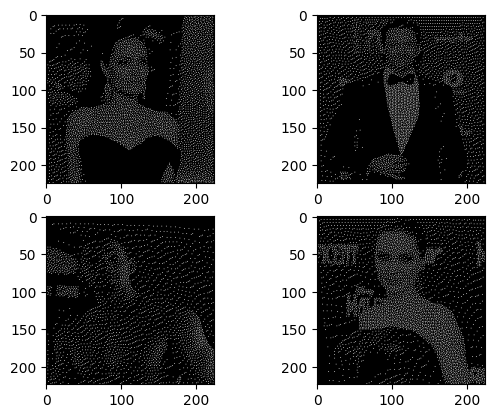

In [3]:
import matplotlib.pyplot as plt

# 创建一个新的数据加载器，只加载4张图片
data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# 获取一批图片和对应的标签
imgs, labels, id = next(iter(data_loader))

# 创建一个新的图像窗口
plt.figure()

# 遍历每一张图片
for i in range(4):
    # 将图片的像素值范围从[0, 1]转换为[0, 255]
    img = imgs[i].cpu().numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = img.clip(0, 1)

    # 创建一个新的子图
    plt.subplot(2, 2, i+1)

    # 显示图片
    plt.imshow(img)

    # 显示标签
    #plt.title(f'Label: {labels[i]}')

# 显示图像窗口
plt.show()

In [4]:
train_model(epoch)

Epoch 1, Train Loss: 19823.051953125, Val Loss: 19119.7724609375
Epoch 2, Train Loss: 18103.222265625, Val Loss: 19075.419921875
Epoch 3, Train Loss: 14587.037109375, Val Loss: 18063.076171875
Epoch 4, Train Loss: 10238.4494140625, Val Loss: 16469.080078125
Epoch 5, Train Loss: 5972.06767578125, Val Loss: 11718.48681640625
Epoch 6, Train Loss: 3429.8740234375, Val Loss: 4353.6070556640625
Epoch 7, Train Loss: 2402.733984375, Val Loss: 7413.259521484375
Epoch 8, Train Loss: 1783.7162109375, Val Loss: 4218.00537109375
Epoch 9, Train Loss: 1263.3097778320312, Val Loss: 3658.20849609375
Epoch 10, Train Loss: 1181.0325439453125, Val Loss: 3443.3824462890625
Epoch 11, Train Loss: 794.2049438476563, Val Loss: 3654.720947265625
Epoch 12, Train Loss: 595.8048156738281, Val Loss: 2968.742431640625
Epoch 13, Train Loss: 509.59674072265625, Val Loss: 2843.5333251953125
Epoch 14, Train Loss: 420.49583740234374, Val Loss: 2740.46728515625
Epoch 15, Train Loss: 467.36546630859374, Val Loss: 2686.7563

In [5]:
# 创建模型实例
model = Net()
if torch.cuda.device_count() > 1:
  print("Use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)
model = model.to(device)

# 加载最佳模型
if torch.cuda.device_count() > 1:
    model.module.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
else:
    model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

# 切换到评估模式
model.eval()

predictions = []
real_values = []

with torch.no_grad():
    for imgs, labels, ids in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        # 前向传播
        outputs = model(imgs)
        # 保存预测值和真实值
        predictions.extend(outputs.tolist())
        real_values.extend(labels.tolist())

# 将预测值和真实值转换为numpy数组
predictions = np.array(predictions).astype(int)
real_values = np.array(real_values).astype(int)

# 确保预测值的第一个参数为奇数
predictions[:, 0] = predictions[:, 0] + (predictions[:, 0] % 2  == 0)

# 打印预测值和真实值
print('Predictions:', predictions)
print('Real Values:', real_values)

Use 2 GPUs!
Predictions: [[  5 300   5]
 [  5 231   4]
 [  5 234   4]
 [  3 129   2]
 [  7 318   6]
 [  1  90   1]
 [  1  97   1]
 [  3 180   3]
 [  5 278   5]
 [  3 185   3]
 [  7 339   6]
 [  5 221   4]
 [  3 128   2]
 [  3 183   3]
 [  3 126   2]
 [  5 253   4]
 [  5 252   4]
 [  3 126   2]
 [  3 121   2]
 [  3 113   2]
 [  1  77   1]
 [  3 178   3]
 [  3 104   2]
 [  5 303   5]
 [  3 117   2]
 [  5 305   5]
 [  5 253   4]
 [  1  88   1]
 [  3 115   2]
 [  5 277   5]
 [  5 302   5]
 [  3 146   2]
 [  3 163   3]
 [  5 261   4]
 [  3 178   3]
 [  5 307   5]
 [  5 238   4]
 [  3 156   3]
 [  5 285   5]
 [  1  92   1]
 [  3 123   2]
 [  3  98   1]
 [  3 197   3]
 [  3 147   2]
 [  7 315   5]
 [  3 189   3]
 [  3 202   3]
 [  7 317   5]
 [  3 121   2]
 [  7 373   7]
 [  3 187   3]
 [  5 276   5]
 [  1  77   1]
 [  1  93   1]
 [  5 310   5]
 [  3 200   3]
 [  1  90   1]
 [  3 177   3]
 [  3 202   3]
 [  5 238   4]
 [  5 239   4]
 [  5 220   4]
 [  5 300   5]
 [  5 298   5]
 [  5 210   4]


In [6]:
def block_no_expand(image_path):
    image=np.array(Image.open(image_path))
    image_lab=cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image_lab[:,:,-1]=np.interp(image_lab[:,:,-1],(0,255),(0,255/4))
    image_rgb=cv2.cvtColor(image_lab,cv2.COLOR_HSV2RGB)
    image_ht=Image.fromarray(image_rgb).convert("1")
    image_ht=img_as_ubyte(image_ht)
    return image_ht

def Filter(image_path, radius=3, sigma_s=100, cnts=3):
    img = block_no_expand(image_path)
    pil_halftone = Image.fromarray(img).convert('L').convert("1")
    halftone = img_as_ubyte(pil_halftone)
    ref = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    def IHT(I, radius=3, sigma_s=100, cnts=3):
        dehalftoned = halftone.copy()
        for i in range(cnts):
            dehalftoned = cv2.bilateralFilter(I, radius, sigma_s, sigma_s, dst=dehalftoned)
        return dehalftoned

    I = cv2.GaussianBlur(halftone.copy(), (radius, radius), 0)
    dehalftoned = IHT(I, radius, sigma_s, cnts)
    ehist = cv2.equalizeHist(dehalftoned)

    return ehist

In [7]:
def display_images(show, id, original_img, filtered_img_default, filtered_img_best, filtered_img_nn, params_best, params_nn):
    # 计算PSNR和SSIM
    psnr_default = psnr(original_img, filtered_img_default)
    ssim_default = ssim(original_img, filtered_img_default)
    psnr_best = psnr(original_img, filtered_img_best)
    ssim_best = ssim(original_img, filtered_img_best)
    psnr_nn = psnr(original_img, filtered_img_nn)
    ssim_nn = ssim(original_img, filtered_img_nn)

    # 显示图像
    if show:
        plt.figure(figsize=(16, 10))

        plt.subplot(1, 4, 1)
        plt.imshow(original_img, cmap='gray')
        plt.title(f'GT\n{id:04d}')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(filtered_img_default, cmap='gray')
        plt.title(f'Default\nPSNR: {psnr_default:.2f}\nSSIM: {ssim_default:.2f}')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(filtered_img_best, cmap='gray')
        plt.title(f'Brute: {params_best}\nPSNR: {psnr_best:.2f}\nSSIM: {ssim_best:.2f}')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(filtered_img_nn, cmap='gray')
        plt.title(f'Pred: {params_nn}\nPSNR: {psnr_nn:.2f}\nSSIM: {ssim_nn:.2f}')
        plt.axis('off')

        plt.show()

    return psnr_default, ssim_default, psnr_best, ssim_best, psnr_nn, ssim_nn

# 初始化PSNR总和
psnr_default_total = 0
psnr_best_total = 0
psnr_nn_total = 0
# 初始化SSIM总和
ssim_default_total = 0
ssim_best_total = 0
ssim_nn_total = 0

with torch.no_grad():
    for i, (imgs, labels, ids) in enumerate(test_dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        # 取批次中的第一张图像
        n = imgs.size(0)
        for j in range(n):
            # 计算全局图像索引
            global_index = i * bs + j
            #print(global_index)
            image_path = f"/kaggle/input/celeb-m/Celebrity Faces Dataset/{ids[j]:04d}.jpg"
            original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # 使用Filter函数处理图像
            filtered_img_default = Filter(image_path)
            params_best = real_values[global_index]
            filtered_img_best = Filter(image_path, *params_best)
            params_nn = predictions[global_index]
            filtered_img_nn = Filter(image_path, *params_nn)

            # 调用函数显示图像并获取PSNR和SSIM
            psnr_default, ssim_default, psnr_best, ssim_best, psnr_nn, ssim_nn = display_images(False, ids[j], original_img, filtered_img_default, filtered_img_best, filtered_img_nn, params_best, params_nn)

            # 添加到PSNR和SSIM总和
            psnr_default_total += psnr_default
            psnr_best_total += psnr_best
            psnr_nn_total += psnr_nn
            ssim_default_total += ssim_default
            ssim_best_total += ssim_best
            ssim_nn_total += ssim_nn

In [8]:
# 计算图像的总数
total_images = len(predictions)

# 计算平均PSNR
psnr_default_avg = psnr_default_total / total_images
psnr_best_avg = psnr_best_total / total_images
psnr_nn_avg = psnr_nn_total / total_images

# 计算平均SSIM
ssim_default_avg = ssim_default_total / total_images
ssim_best_avg = ssim_best_total / total_images
ssim_nn_avg = ssim_nn_total / total_images

print(f"Average PSNR for default: {psnr_default_avg}")
print(f"Average PSNR for best: {psnr_best_avg}")
print(f"Average PSNR for nn_predict: {psnr_nn_avg}")

print(f"Average SSIM for default: {ssim_default_avg}")
print(f"Average SSIM for best: {ssim_best_avg}")
print(f"Average SSIM for nn_predict: {ssim_nn_avg}")

Average PSNR for default: 14.466119139035623
Average PSNR for best: 16.307618784099514
Average PSNR for nn_predict: 15.480770758641219
Average SSIM for default: 0.2320919793000731
Average SSIM for best: 0.4060634098854834
Average SSIM for nn_predict: 0.319885277811617
